# Comparing scans coming from different instruments.

To quantitivaly compare the acquisition acquired using two differnet techniuqes, the scan must be registered. Here is presented review of the possible methods that can be used for this task. Possibile pipeline are shown to automatize the task introducing a poisitining process before the registerign step. 

## Registering ROI with the same scanning step over a bigger image
Many time the registration algorithm have to deal with image of the same or comparable time. This is not the case when the acquitions are to be compared with ROI acquired with other techniuqe. The most common method is to use control points and manual registration algorithm. It has been tried to used **template matching** to speed up this task. Before the actual registriaion phase it has been tried to use template matching for positining the ROI in apporximately the same region on the fixed image. 


### Creation of a sample surface
Initialy the algorithm has been tested on a surface generated with function.

In [ ]:
from scipy import ndimage,misc
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Test data
x, y = np.mgrid[-5:5:0.1, -5:5:0.1]

FI = np.array(np.sqrt(x**2 + y**2) + np.sin(x**2 + y**2) )#Fixed image
#Real coordinates of the ROI to be registered
xi = 10
xf = 20
yi = 25
yf = 45
MI = np.array(FI[yi:yf,xi:xf].copy()) + 160 #Moving image

From this array has been extracted a ROI to be tested. This will be the **moving image** while the whole image will be the **the fixed image**. The moving image has been modified adding a constant to the whole array to test if the algorithm work in case the two surface do not have the base line at the same height.

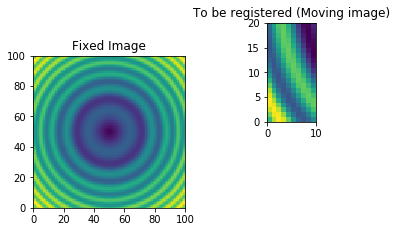

In [4]:
#Make the arrays have the same dimensions
MI_ss = np.full(FI.shape, np.nan)
MI_ss[:MI.shape[0],:MI.shape[1]] = MI
MI_ss_masked = np.ma.masked_invalid(MI_ss)


#Visualizing test data
fig = plt.figure()
ax = fig.add_subplot(121)
ax.set_title('Fixed Image')
ax.pcolormesh(FI)
ax.set_aspect('equal')
ax2 = fig.add_subplot(222)
ax2.pcolormesh(MI)
ax2.set_title('To be registered (Moving image)')
ax2.set_aspect('equal')
plt.show()

### Positioning using template matching over modified generated surfaces.
cv2.matchTempalte has been used for this task. In this case the match is successful even if the cosntant is added. 

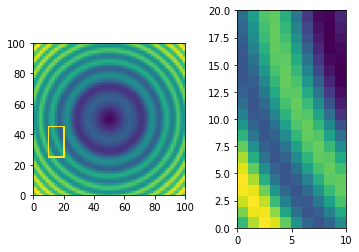

In [9]:
import cv2
FI_255 = np.array((FI - np.nanmin(FI))/np.nanmax(FI) * 255, dtype = np.uint8)
MI_255 = np.array((MI - np.nanmin(MI))/np.nanmax(MI) * 255, dtype = np.uint8)
scores = cv2.matchTemplate(FI_255, MI_255, method=cv2.TM_CCORR_NORMED)
            
# get best score and position
min_score, max_score, (min_x, min_y), (max_x, max_y) = cv2.minMaxLoc(scores)

xi_r = max_x
xf_r = max_x + MI_255.shape[1]
yi_r = max_y
yf_r = max_y + MI_255.shape[0]
img_highlighted = FI_255.copy()        
# add a rectangle
rgb=(0,255,0)
ref = (255,0,0) 
stroke=1
cv2.rectangle(img_highlighted, (xi_r,yi_r),(xf_r,yf_r), rgb, stroke)
cv2.rectangle(img_highlighted, (xi,yi),(xf,yf), ref, stroke)
# show
figx = plt.figure()
axx = figx.add_subplot(121)
axx.pcolormesh(img_highlighted)
axx.set_aspect('equal')

FI_crop = FI[yi_r:yf_r,xi_r:xf_r].copy()
axx2 = figx.add_subplot(122)
axx2.pcolormesh(FI_crop)
axx2.set_aspect('equal')
plt.show()

This approach in practice **seems not working efficiently** this may be due to substantial differences between the acquisition with the two techniques. Possible line of research could be:
1.  to use **gaussian filters** to level minor differences allowing the matching to be perform only using the features more evident.
2.  to use **masked arrays** filtering acquisition artifacts of the two techniques 

### Positioning using GIS software manual registration tools

GIS software are usually provided with different powerful tools to register raster images. However the surface has to be conerted in a suitable format so that can be loaded in the project. 
GEODAL drivers have been used to export the surface in GEOTIFF format. GEOTIFF allows to store information regarding the reference system and multiple surface can be stored as TIFF channels allowing the creation of a stack. For exporting the data a function of the module `micropro` has been used. 


In [13]:
import micropro
c_br_12 = '/home/opdate/Desktop/SPIE/Brz_t1_d2/Brz_12_t1/Brz_12_t1'
conoscopic  = micropro.ns(c_br_12)
??conoscopic.GEOTIFF()

WORKING ON:
Brz_12_t1
93.0
Num. rows: 1161, Num. Cols: 1861
Size expected: 2160621, Size retrieved: 2162482
WARNING! SIZES DO NOT MATCH!
Difference: -1861
Maybe rows: -2
Maybe cols: -1
 I am trying to fix it passing 1 for rows and 0 for coloumns
Now I am correcting the x-y range


The drawback of this method is that the surface must be recorded as an image and this could lead to some issues when working with it again for further processing.